In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score


## Exploring The Server Machine Dataset

In [47]:
dataset = 'SMD'
data_path = "../ServerMachineDataset/processed"
x_dim = 38

file = 1, 2

In [48]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_train.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df = pd.DataFrame(data)
df.head()

0         1         2         3         4         5         6    7   \
0  0.16  0.058339  0.090032  0.114586  0.122642  0.899967  0.262767  0.0   
1  0.11  0.048404  0.083601  0.111170  0.122642  0.859680  0.262093  0.0   
2  0.11  0.044599  0.076923  0.107227  0.122642  0.860669  0.261962  0.0   
3  0.12  0.053266  0.075686  0.105125  0.122642  0.781639  0.184000  0.0   
4  0.11  0.044599  0.070492  0.101708  0.122642  0.702331  0.106054  0.0   

         8         9   ...   28   29        30   31    32        33   34   35  \
0  0.000746  0.012437  ...  0.0  0.0  0.045032  0.0  0.25  0.090278  0.0  0.0   
1  0.000187  0.000315  ...  0.0  0.0  0.028284  0.0  0.25  0.076389  0.0  0.0   
2  0.000187  0.000005  ...  0.0  0.0  0.034611  0.0  0.25  0.069444  0.0  0.0   
3  0.000187  0.000438  ...  0.0  0.0  0.071083  0.0  0.25  0.069444  0.0  0.0   
4  0.000840  0.000000  ...  0.0  0.0  0.025307  0.0  0.25  0.069444  0.0  0.0   

    36   37  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 38 columns]

<Figure size 432x288 with 0 Axes>

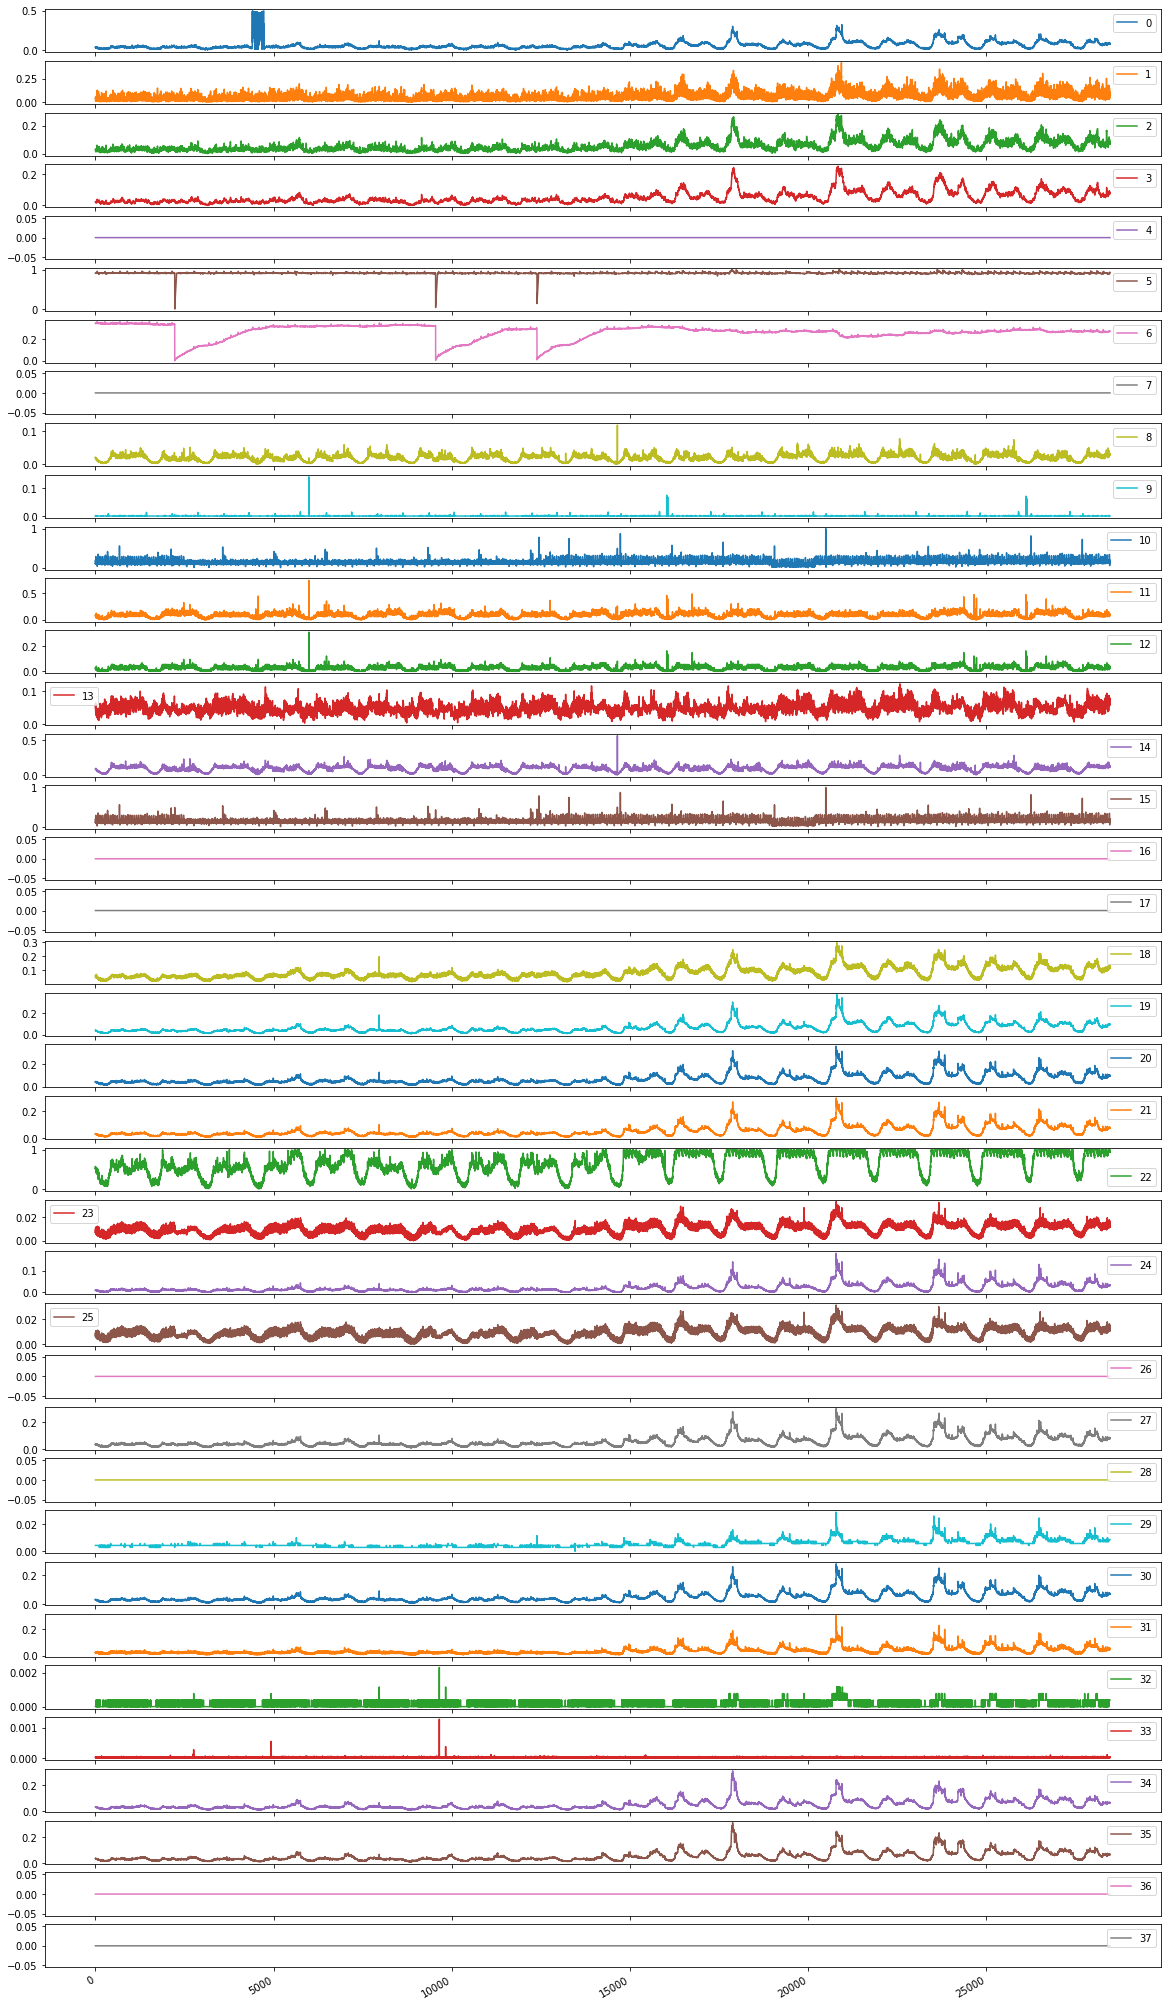

In [4]:
plt.tight_layout()
df.plot(subplots=True, figsize=(20,40))
plt.show();

In [50]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df_test = pd.DataFrame(data)

f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test_label.pkl', "rb")
test_labels = pickle.load(f)
f.close()
df_test['Anomaly'] = test_labels

<Figure size 432x288 with 0 Axes>

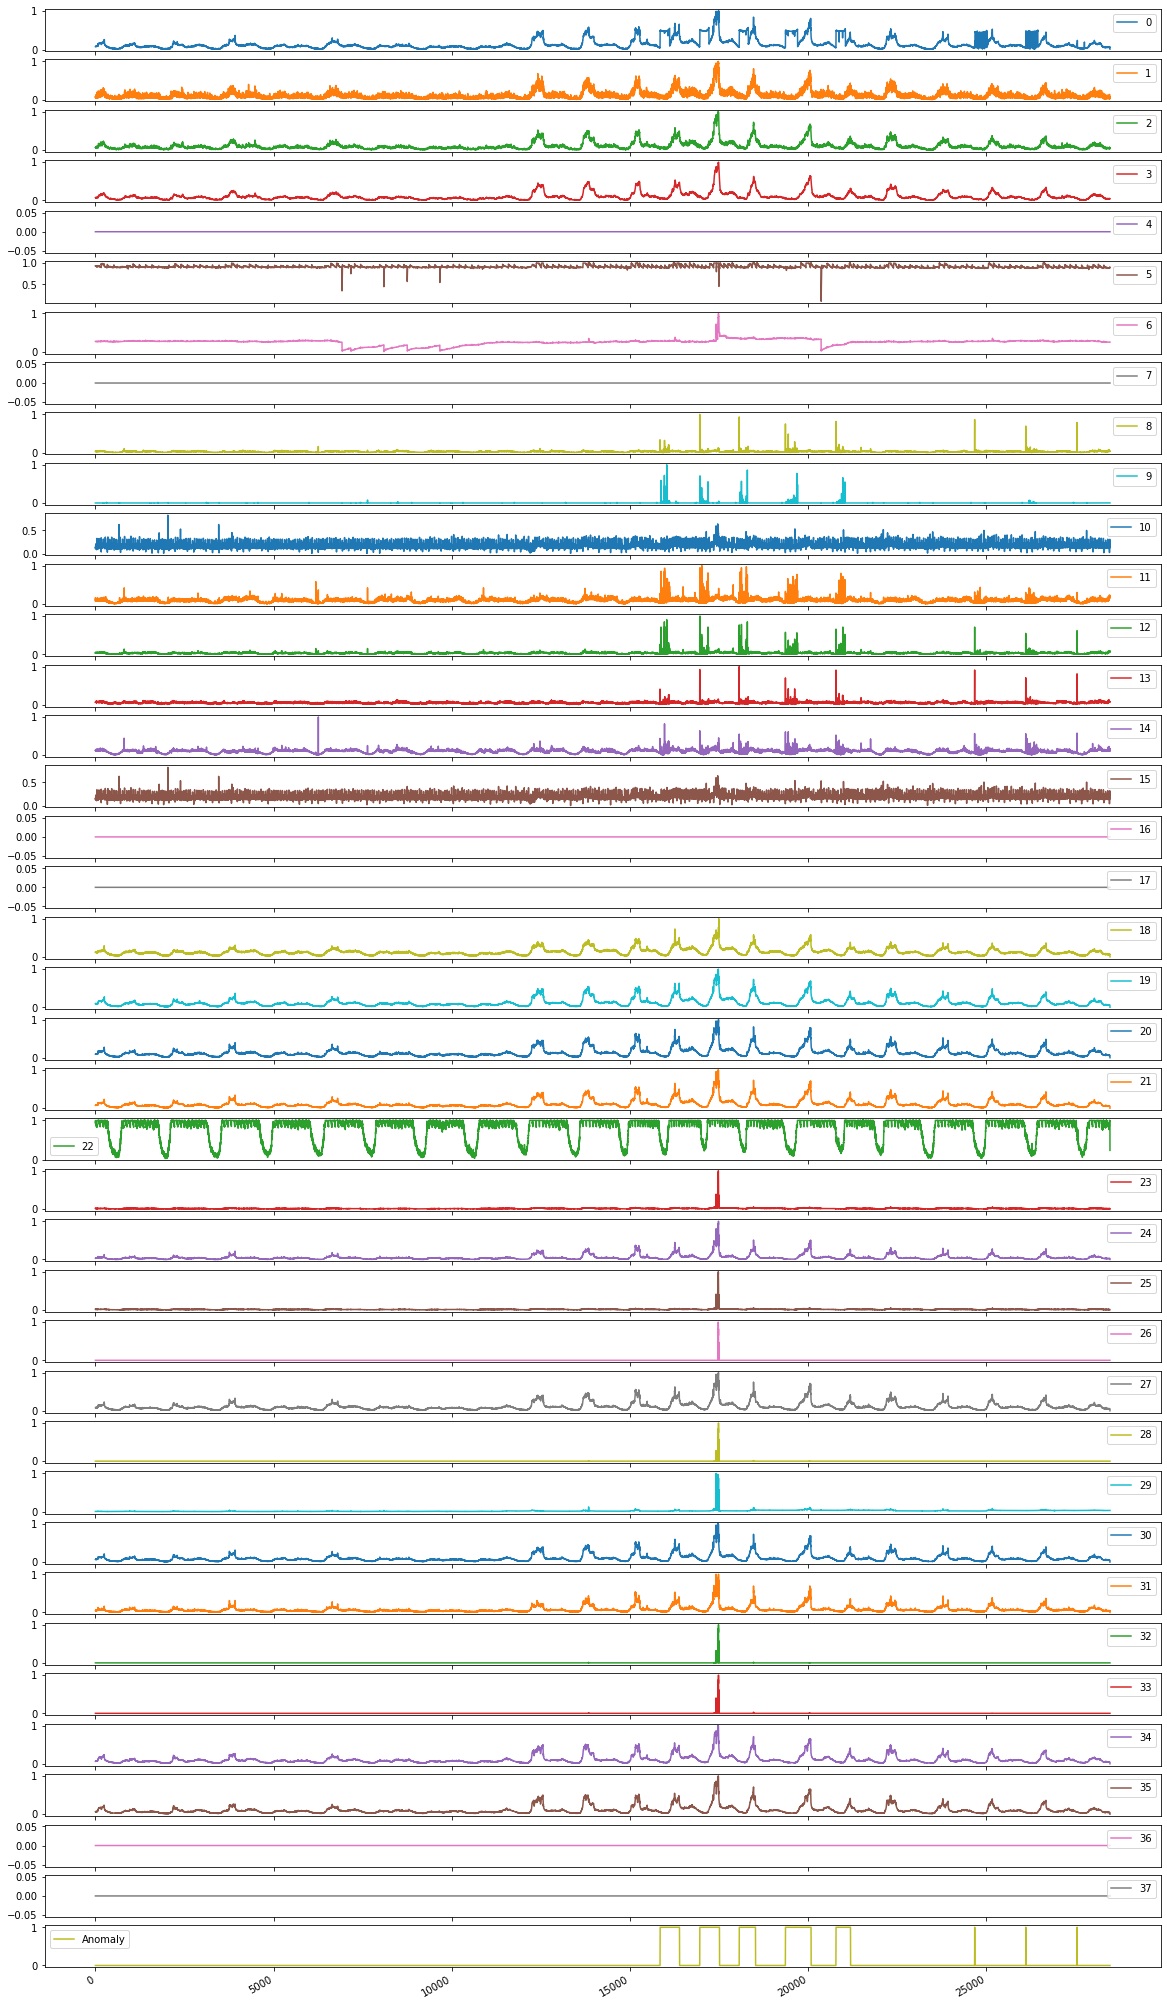

In [7]:
plt.tight_layout()
df_test.plot(subplots=True, figsize=(20,40))
plt.show();

In [8]:
df.shape[0] + df_test.shape[0]

56958

In [52]:
df_comb = pd.concat([df, df_test], ignore_index=True)
df_comb.shape

(47388, 39)

<Figure size 432x288 with 0 Axes>

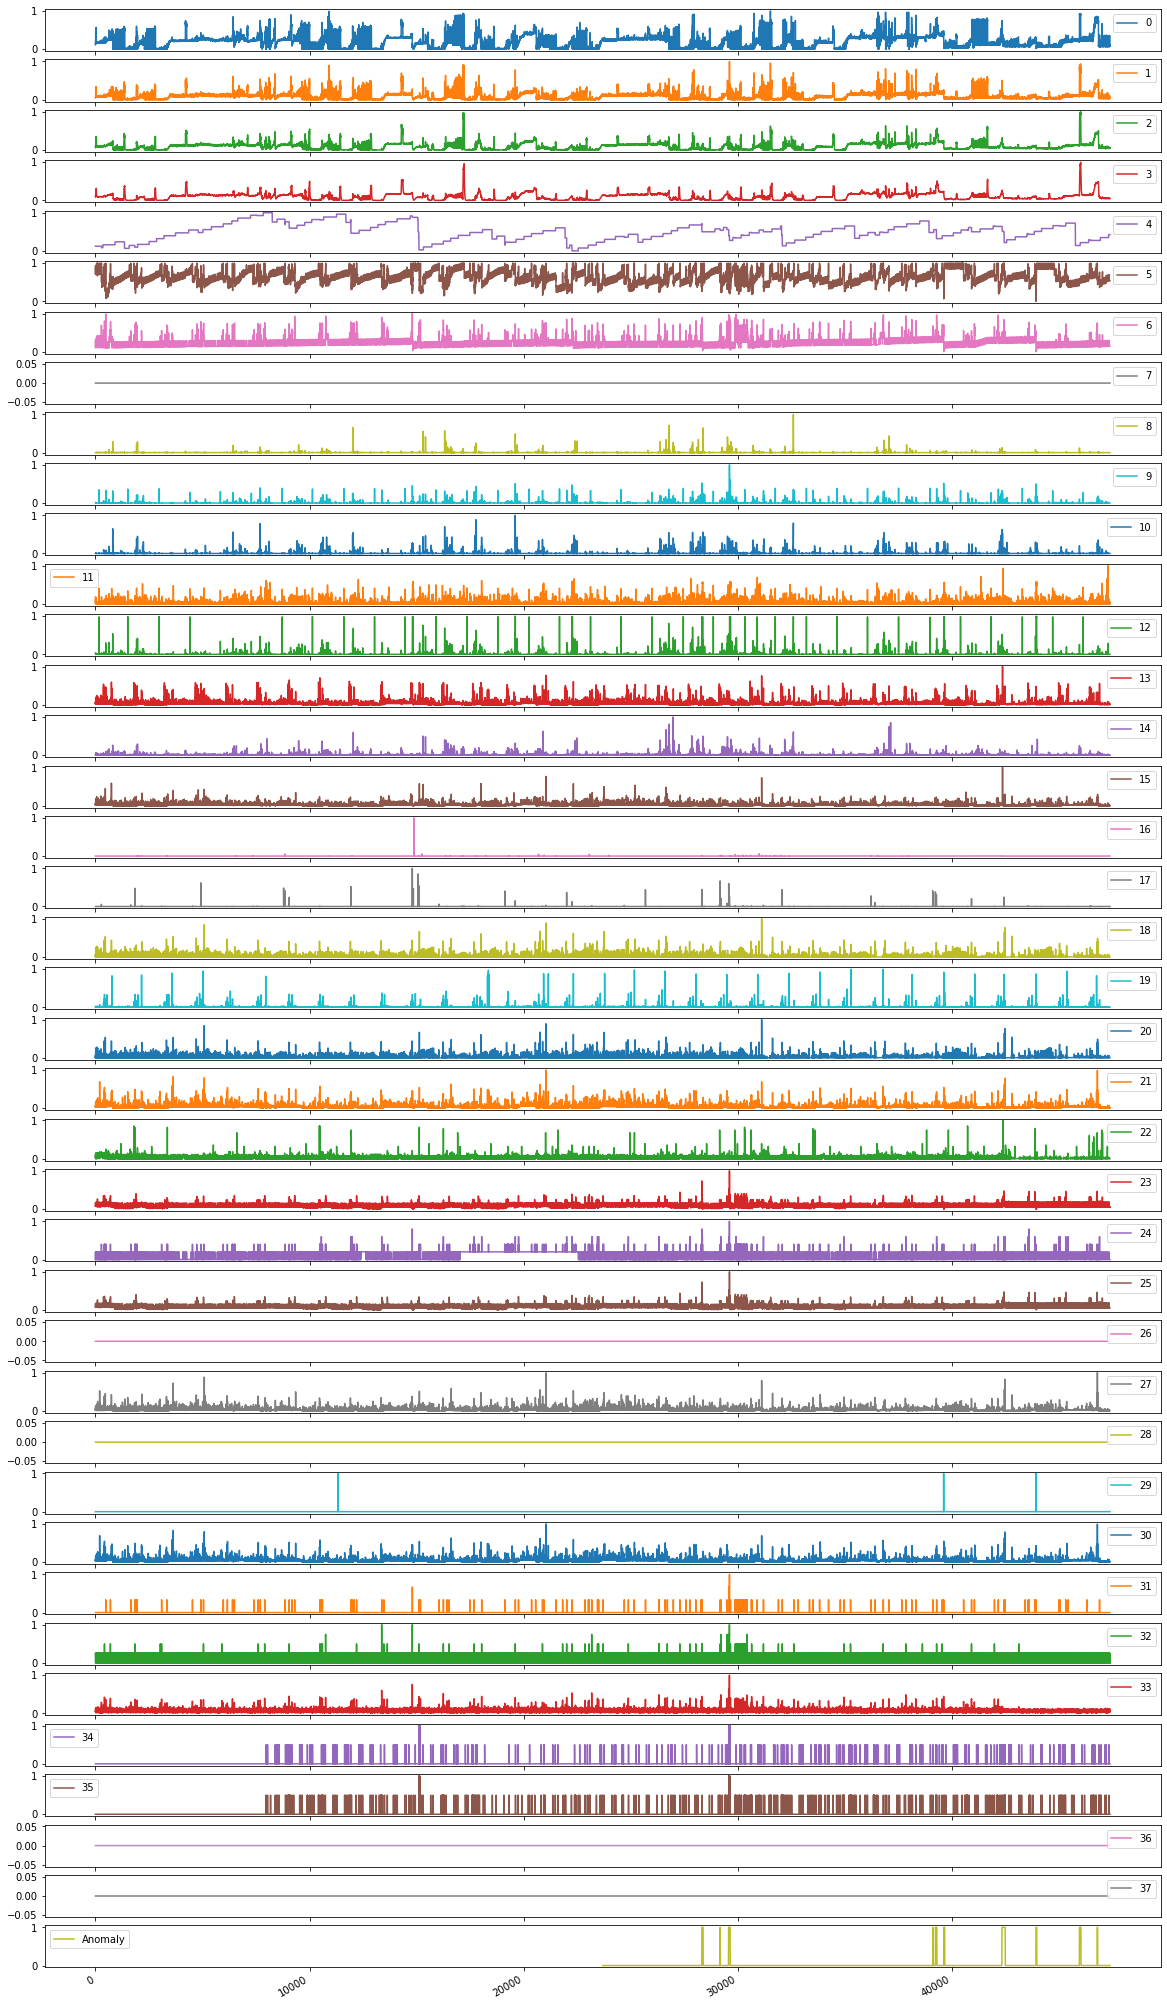

In [53]:
plt.tight_layout()
df_comb.plot(subplots=True, figsize=(20,40))
plt.show();

## Exploring Spectral Residual for removing outliers in training data 

In [10]:
from alibi_detect.od import SpectralResidual
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_ts
from scipy import interpolate

od = SpectralResidual(
    threshold=None,
    window_amp=500,
    window_local=500,
    n_est_points=10,
    n_grad_points=5
)

No threshold level set. Need to infer threshold using `infer_threshold`.


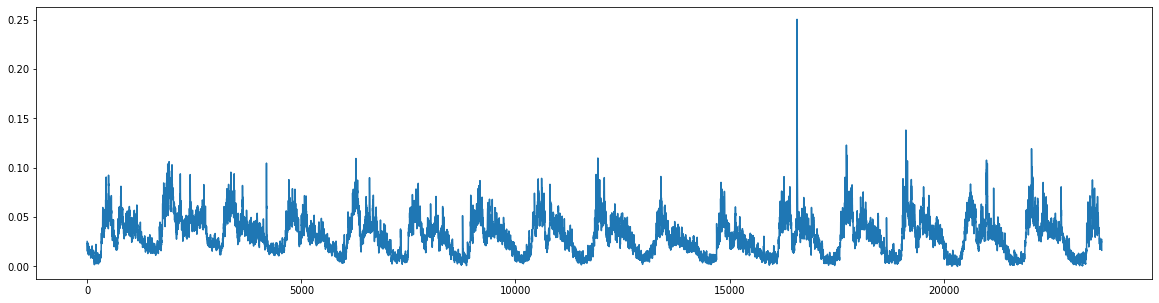

In [11]:
x = df.iloc[:,2].values
plt.figure(figsize=(20, 5))
plt.plot(x)

In [12]:
od.infer_threshold(x, threshold_perc=99.9)
od.threshold

4.166644035446716

In [13]:
preds = od.predict(
    x,
    #t=t,  # array with timesteps, assumes dt=1 between observations if omitted
    return_instance_score=True
)

In [14]:
preds

{'data': {'instance_score': array([ 6.96504892,  1.79670882,  3.63287959, ..., -0.42278145,
          0.37681006, -0.77091269]),
  'feature_score': None,
  'is_outlier': array([1, 0, 0, ..., 0, 0, 0])},
 'meta': {'name': 'SpectralResidual',
  'detector_type': 'online',
  'data_type': 'time-series'}}

In [15]:
a_scores = preds['data']['instance_score']
is_a = preds['data']['is_outlier']

print(is_a.shape)
print(x.shape)

(23693,)
(23693,)


In [16]:
x_interp = x.copy()
x_interp[np.where(is_a == 1)] = np.NaN
x_interp = pd.Series(x_interp)
print(pd.isna(x_interp).sum())
x_interp = x_interp.interpolate(method='pad')
print(pd.isna(x_interp).sum())

24
1


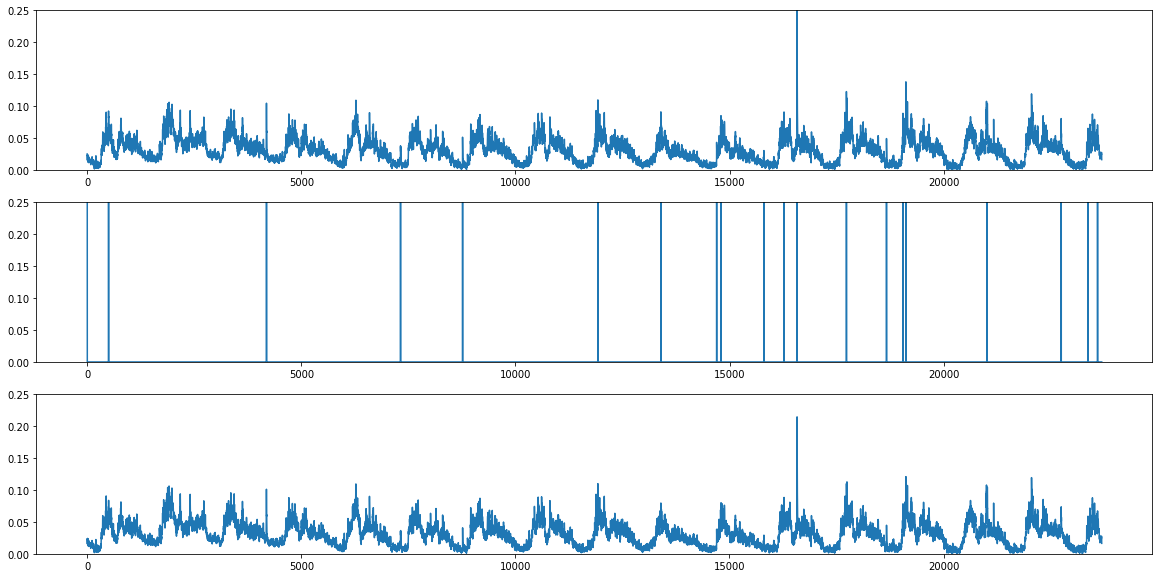

In [17]:

fig, axs = plt.subplots(3, figsize=(20,10))
axs[0].set_ylim([0, max(x)])
axs[1].set_ylim([0, max(x)])
axs[2].set_ylim([0, max(x)])

axs[0].plot(x)
axs[1].plot(is_a)
axs[2].plot(x_interp)


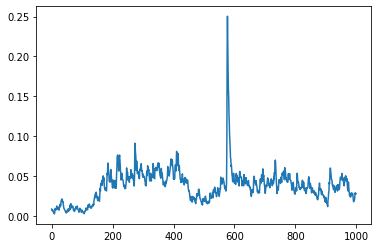

In [18]:
plt.plot(x[16000:17000])

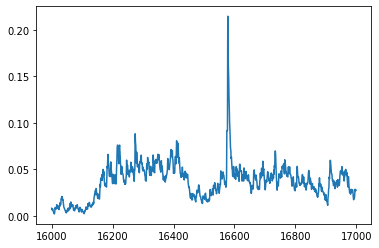

In [19]:
plt.plot(x_interp[16000:17000])

## Results (forecastings, reconstructions, anomaly scores) for trained model on train and test data

In [98]:
output = pd.read_pickle('../output/smd/1-1/test_out.pkl')

In [99]:
output.head()

Pred_0   Recon_0    True_0  A_Score_0    Pred_1   Recon_1    True_1  \
0  0.160394  0.144354  0.150538   0.016040  0.144297  0.134284  0.153602   
1  0.159652  0.147404  0.161290   0.015524  0.143441  0.132097  0.159958   
2  0.162557  0.148108  0.161290   0.014449  0.145655  0.135663  0.150424   
3  0.161624  0.147504  0.161290   0.014121  0.144707  0.130257  0.115466   
4  0.161237  0.148496  0.161290   0.012847  0.144656  0.130496  0.137712   

   A_Score_1    Pred_2   Recon_2  ...       Pred_36  Recon_36  True_36  \
0   0.028623  0.142522  0.136945  ... -5.512412e-07  0.000142      0.0   
1   0.044378  0.141738  0.137706  ... -5.552413e-07  0.000510      0.0   
2   0.019530  0.144181  0.136449  ... -4.766683e-07  0.000575      0.0   
3   0.044032  0.143105  0.130066  ... -5.840744e-07 -0.000447      0.0   
4   0.014160  0.142958  0.131357  ... -6.173294e-07  0.000597      0.0   

   A_Score_36   Pred_37  Recon_37  True_37  A_Score_37  Pred_Anomaly  \
0    0.000143 -0.000123 -0.001177      0.0    0.001300            -1   
1    0.000510 -0.000123 -0.002048      0.0    0.002171            -1   
2    0.000575 -0.000135 -0.000564      0.0    0.000699            -1   
3    0.000448 -0.000131 -0.001258      0.0    0.001389            -1   
4    0.000598 -0.000131 -0.000727      0.0    0.000858            -1   

   True_Anomaly  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 154 columns]

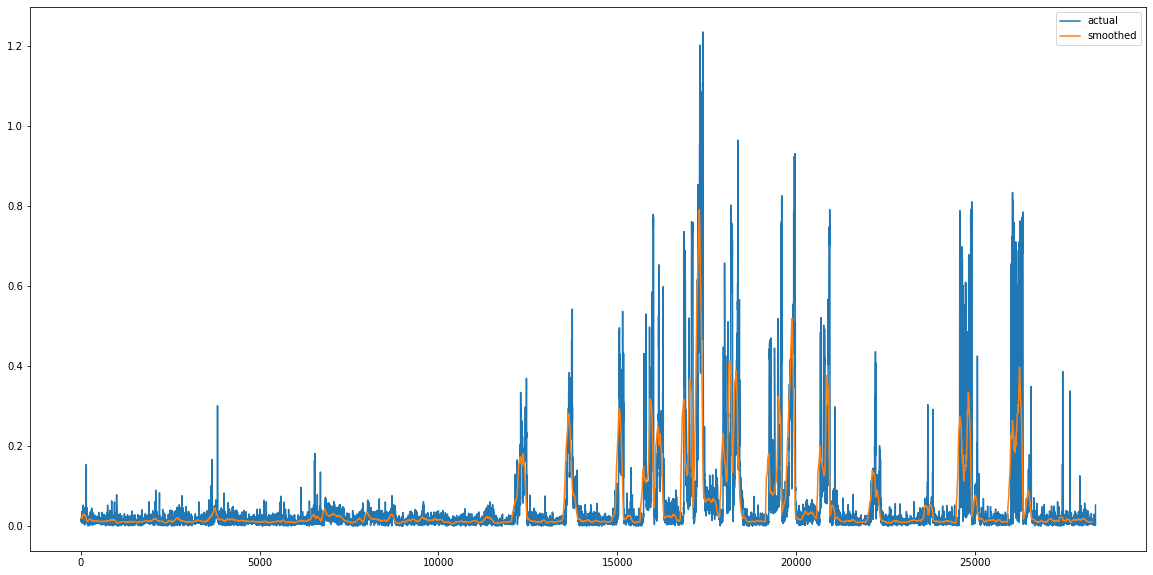

In [124]:
xi = output['A_Score_0'].values
N = 100
si = np.convolve(xi, np.ones(N)/N, mode='valid')

plt.figure(figsize=(20, 10))
plt.plot(xi, label='actual')
plt.plot(si, label='smoothed')

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

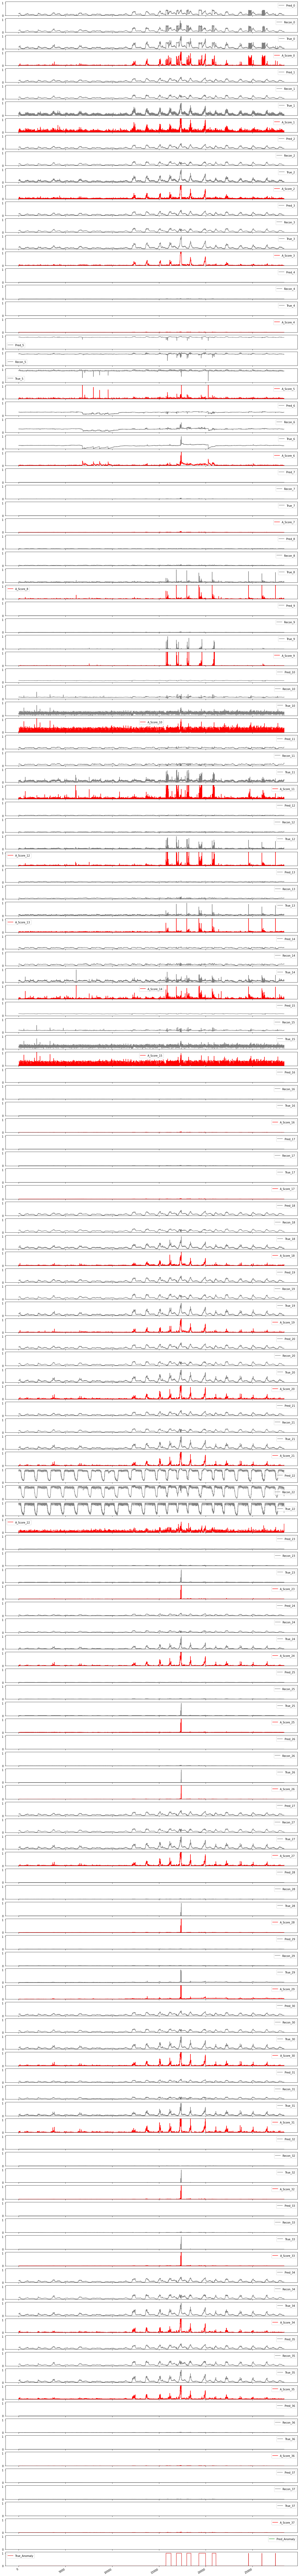

In [101]:
plt.tight_layout()
colors = ['gray', 'gray', 'gray', 'r']*(output.shape[1] // 4)
output.plot(subplots=True, figsize=(20,200), ylim=(0,1.1), style=colors)
plt.show();

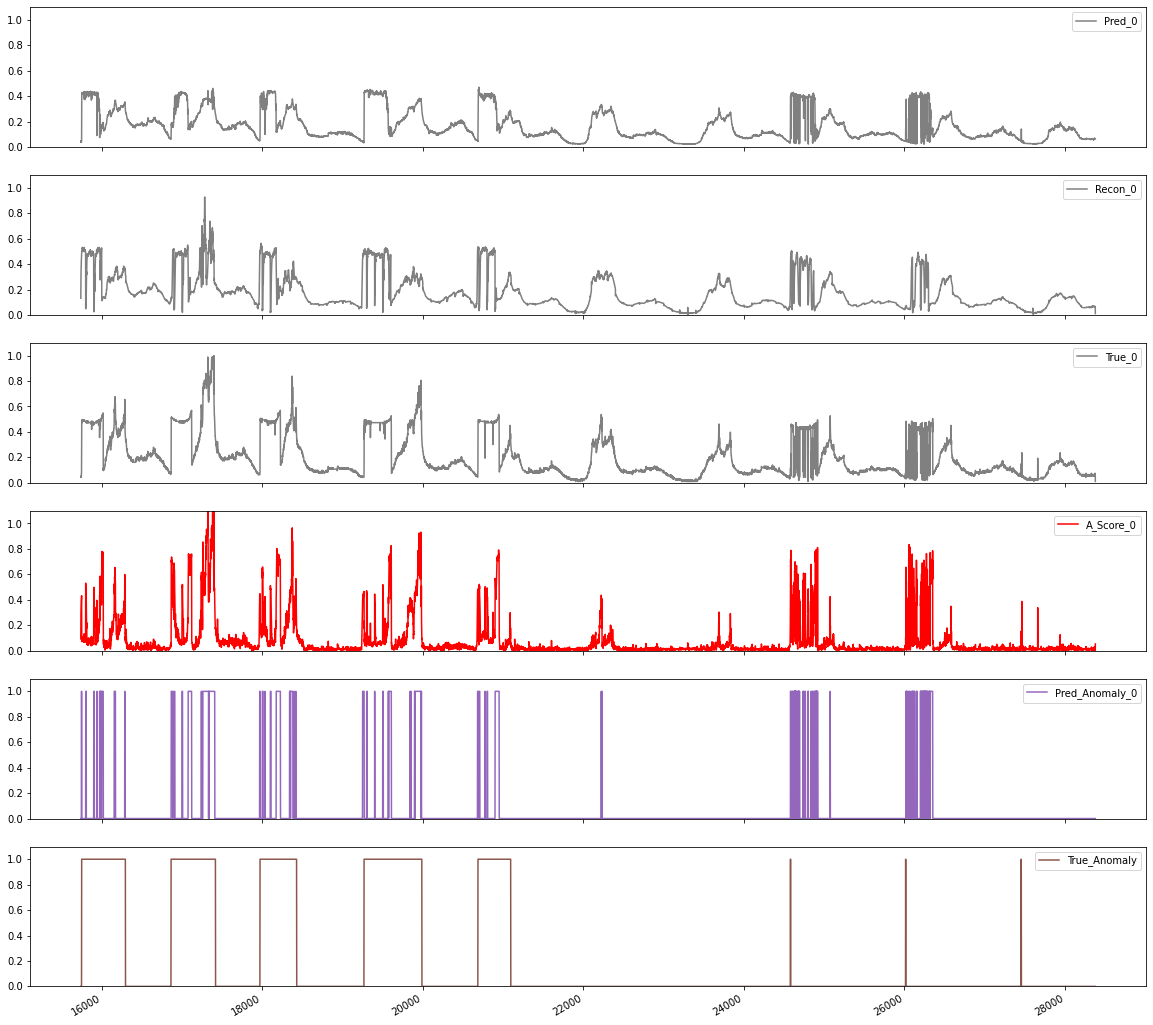

In [103]:
i = 0

# Calculate threshold loss = mean + 3std
rses = output.loc[:, f'A_Score_{i}']
thresh = np.mean(rses) + 3*np.std(rses)

output[f'Pred_Anomaly_{i}'] = (rses > thresh).astype(int)

start, end = 15849, 16368
df = output.loc[start-110:, [f'Pred_{i}', f'Recon_{i}', f'True_{i}', f'A_Score_{i}', f'Pred_Anomaly_{i}','True_Anomaly']]
df.plot(subplots=True, figsize=(20, 20), ylim=(0,1.1), style=['gray', 'gray', 'gray', 'r'])
plt.show()

In [104]:
print(precision_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))
print(recall_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))
print(f1_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))

0.7358490566037735
0.23162583518930957
0.35234330886504794


<Figure size 1440x720 with 0 Axes>

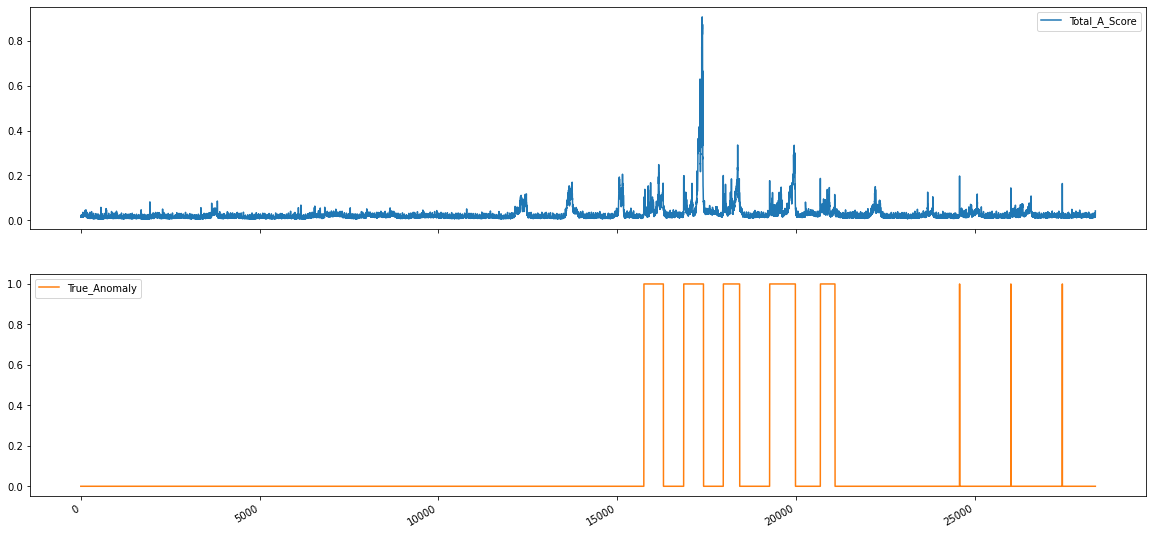

In [105]:
rses = output.loc[:, [f'A_Score_{i}' for i in range(x_dim)]]
output['Total_A_Score'] = rses.mean(1)

plt.figure(figsize=(20, 10))
start, end = 15849, 16368
df = output.loc[:, ['Total_A_Score', 'True_Anomaly']]
df.plot(subplots=True, figsize=(20, 10))
plt.show()


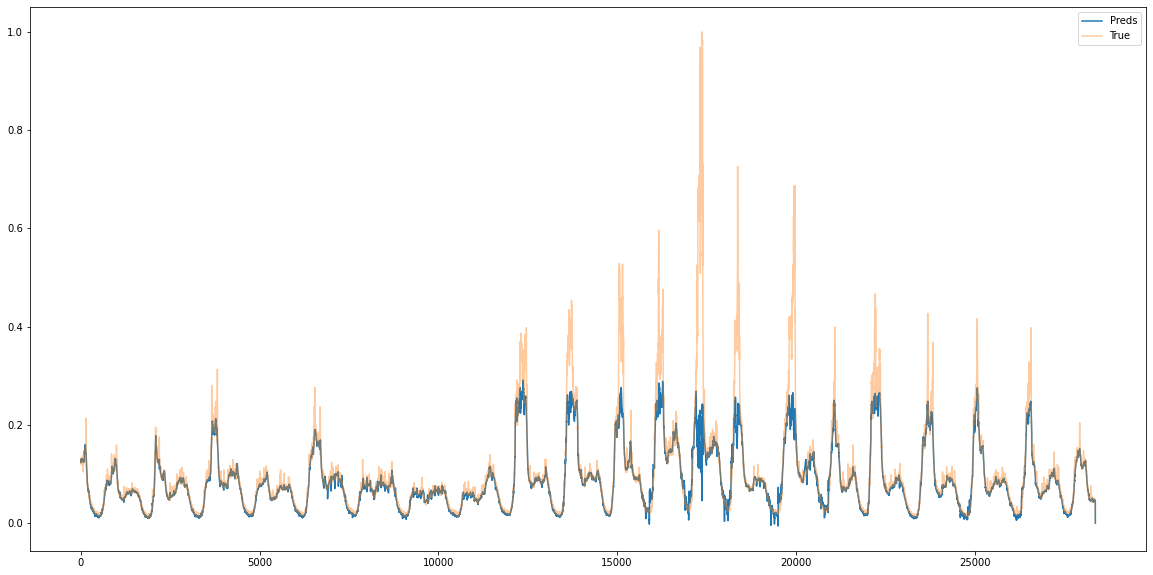

In [106]:
i = 30
# Plot
plt.figure(figsize=(20, 10))
recon = output.loc[:, [f'Recon_{i}']]
true_y = output.loc[:, [f'True_{i}']]

plt.plot(recon.values, label='Preds')
plt.plot(true_y.values, label='True', alpha=0.4)

plt.legend()

In [91]:
# Compute anomaly for every feature
for i in range(38):
    rses = output.loc[:, f'A_Score_{i}']
    thresh = np.mean(rses) + 20*np.std(rses)
    
    output[f'Pred_Anomaly_{i}'] = (rses > thresh).astype(int)

anomaly_preds = output.loc[:, [f'Pred_Anomaly_{i}' for i in range(38)]]
print(anomaly_preds.shape)

output['Pred_Anomaly_Global'] = (np.sum(anomaly_preds, 1) > 1).astype(int)
output.head()

(28379, 38)


Pred_0   Recon_0    True_0  A_Score_0    Pred_1   Recon_1    True_1  \
0  0.304307  0.291402  0.304348   0.012987  0.329090  0.316140  0.364322   
1  0.304755  0.277140  0.326086   0.070278  0.326878  0.304189  0.379398   
2  0.309814  0.307529  0.326086   0.034829  0.332243  0.349928  0.356785   
3  0.307715  0.286296  0.326086   0.058161  0.330117  0.346417  0.273869   
4  0.304350  0.308655  0.326086   0.039167  0.324973  0.358620  0.326634   

   A_Score_1    Pred_2   Recon_2  ...  Pred_Anomaly_29  Pred_Anomaly_30  \
0   0.083415  0.497834  0.485522  ...                0                0   
1   0.127729  0.492856  0.466104  ...                0                0   
2   0.031399  0.501428  0.521326  ...                0                0   
3   0.128796  0.498465  0.507658  ...                0                0   
4   0.033648  0.489563  0.525795  ...                0                0   

   Pred_Anomaly_31  Pred_Anomaly_32  Pred_Anomaly_33  Pred_Anomaly_34  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Pred_Anomaly_35  Pred_Anomaly_36  Pred_Anomaly_37  Pred_Anomaly_Global  
0                0                0                0                    0  
1                0                0                0                    0  
2                0                0                0                    0  
3                0                0                0                    0  
4                0                0                0                    0  

[5 rows x 194 columns]

In [92]:
w = 50
i = w
output['Smooth_Pred_Anomaly_Global'] = 0
while i < output.shape[0]:
    if output.loc[i, 'Pred_Anomaly_Global'] == 1:
        output.loc[i:i+w, 'Smooth_Pred_Anomaly_Global'] = 1
        i += 1
    else:
        i += 1
        

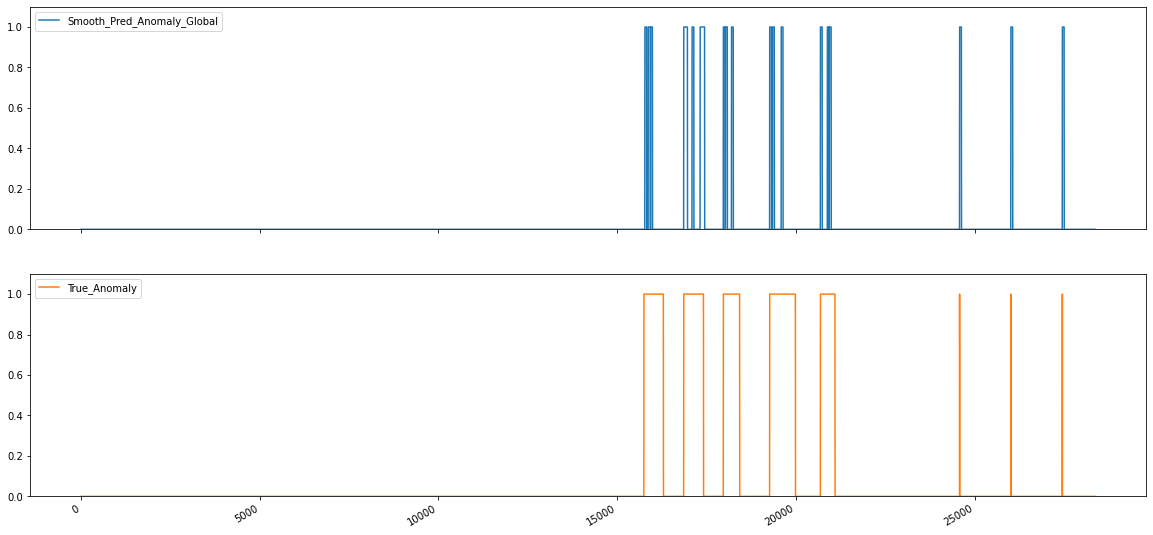

In [93]:
output.loc[:, [f'Smooth_Pred_Anomaly_Global', 'True_Anomaly']].plot(subplots=True, figsize=(20, 10), ylim=(0,1.1))
plt.show()

In [94]:
precision_score(output['True_Anomaly'], output['Smooth_Pred_Anomaly_Global'])

0.8298676748582231

In [95]:
recall_score(output['True_Anomaly'], output['Smooth_Pred_Anomaly_Global'])

0.325909428359317

In [96]:
f1_score(output['True_Anomaly'], output['Smooth_Pred_Anomaly_Global'])

0.4680170575692964

In [172]:
output.head()

Pred_0    True_0   Recon_0  A_Score_0    Pred_1    True_1   Recon_1  \
0  0.163967  0.150538  0.159733   0.022624  0.148099  0.153602  0.147937   
1  0.163736  0.161290  0.173876   0.015032  0.146730  0.159958  0.144312   
2  0.164241  0.161290  0.183700   0.025361  0.147753  0.150424  0.150806   
3  0.165256  0.161290  0.168122   0.010798  0.148259  0.115466  0.144973   
4  0.162633  0.161290  0.174621   0.014674  0.146664  0.137712  0.142749   

   A_Score_1    Pred_2    True_2  ...  Pred_Anomaly_31  Pred_Anomaly_32  \
0   0.011169  0.147328  0.147157  ...                0                0   
1   0.028874  0.145939  0.149387  ...                0                0   
2   0.003053  0.146981  0.151616  ...                0                0   
3   0.062300  0.147469  0.140468  ...                0                0   
4   0.013989  0.145872  0.140468  ...                0                0   

   Pred_Anomaly_33  Pred_Anomaly_34  Pred_Anomaly_35  Pred_Anomaly_36  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Pred_Anomaly_37  Pred_Anomaly_Global  Smooth_Pred_Anomaly_Global  \
0                0                    0                           0   
1                0                    0                           0   
2                0                    0                           0   
3                0                    0                           0   
4                0                    0                           0   

   Total_A_Score  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 195 columns]

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

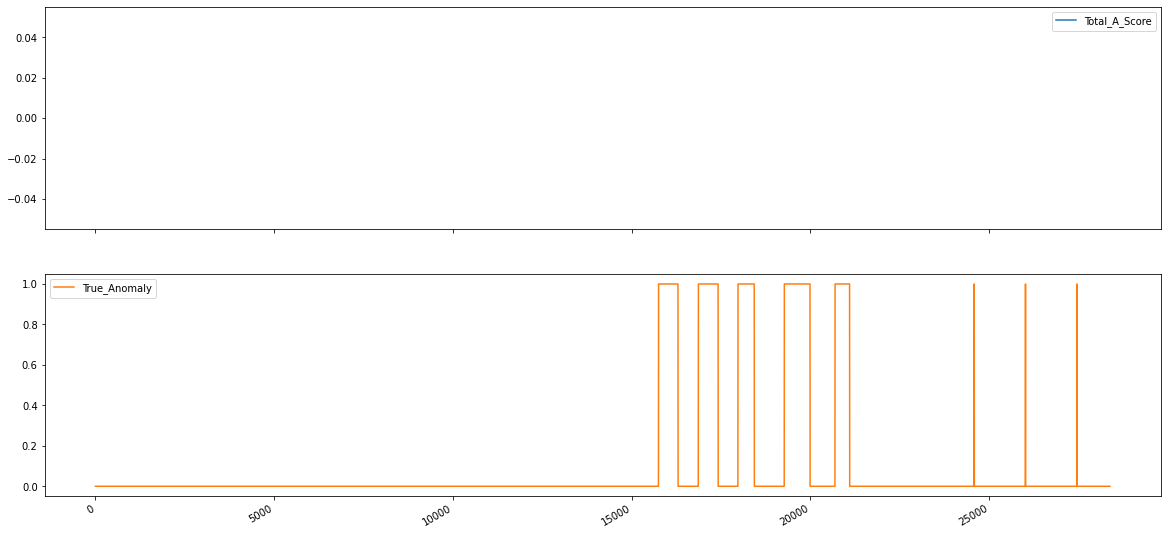

In [171]:
output.loc[:, [f'Total_A_Score', 'True_Anomaly']].plot(subplots=True, figsize=(20, 10))

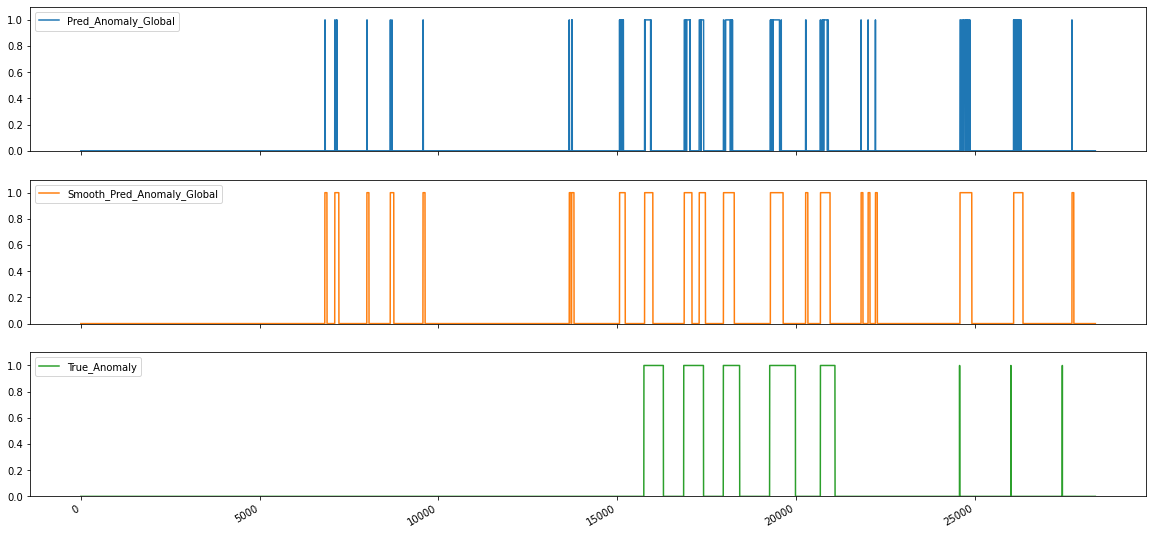

In [30]:
mean_rse = output['mean_rse']
thresh = np.mean(mean_rse) + 1.5*np.std(mean_rse)
output[f'Pred_Anomaly_Global'] = (mean_rse > thresh).astype(int)

w = 50
i = w
output['Smooth_Pred_Anomaly_Global'] = 0
while i < output.shape[0]:
    if output.loc[i, 'Pred_Anomaly_Global'] == 1:
        output.loc[i:i+w, 'Smooth_Pred_Anomaly_Global'] = 1
        i += 1
    else:
        i += 1

output.loc[:, [f'Pred_Anomaly_Global','Smooth_Pred_Anomaly_Global','True_Anomaly']].plot(subplots=True, figsize=(20, 10), ylim=(0,1.1))
plt.show()

In [155]:
from pyextremes import EVA, __version__
import pyextremes
print("pyextremes", __version__)

pyextremes 2.2.1


In [93]:
df = output.copy()
mock_datetimes = pd.date_range('2000-01-01', periods=df.shape[0], freq='T')
df['datetime'] = mock_datetimes
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.tail()

Pred_0    True_0     RSE_0    Pred_1    True_1  \
datetime                                                                
2000-01-20 16:53:00  0.073850  0.075269  0.001419  0.070247  0.037076   
2000-01-20 16:54:00  0.075236  0.075269  0.000033  0.071431  0.051907   
2000-01-20 16:55:00  0.074409  0.064516  0.009893  0.070711  0.025424   
2000-01-20 16:56:00  0.073175  0.064516  0.008659  0.069561  0.080508   
2000-01-20 16:57:00  0.072947  0.064516  0.008431  0.069369  0.056144   

                        RSE_1    Pred_2    True_2     RSE_2    Pred_3  ...  \
datetime                                                               ...   
2000-01-20 16:53:00  0.033171  0.066681  0.046823  0.019858  0.063802  ...   
2000-01-20 16:54:00  0.019524  0.067971  0.047938  0.020033  0.065167  ...   
2000-01-20 16:55:00  0.045287  0.067201  0.039019  0.028182  0.064370  ...   
2000-01-20 16:56:00  0.010947  0.066018  0.050167  0.015851  0.063175  ...   
2000-01-20 16:57:00  0.013225  0.065825  0.047938  0.017887  0.063000  ...   

                     Pred_Anomaly_31  Pred_Anomaly_32  Pred_Anomaly_33  \
datetime                                                                 
2000-01-20 16:53:00                0                0                0   
2000-01-20 16:54:00                0                0                0   
2000-01-20 16:55:00                0                0                0   
2000-01-20 16:56:00                0                0                0   
2000-01-20 16:57:00                0                0                0   

                     Pred_Anomaly_34  Pred_Anomaly_35  Pred_Anomaly_36  \
datetime                                                                 
2000-01-20 16:53:00                0                0                0   
2000-01-20 16:54:00                0                0                0   
2000-01-20 16:55:00                0                0                0   
2000-01-20 16:56:00                0                0                0   
2000-01-20 16:57:00                0                0                0   

                     Pred_Anomaly_37  Pred_Anomaly_Global  \
datetime                                                    
2000-01-20 16:53:00                0                    0   
2000-01-20 16:54:00                0                    0   
2000-01-20 16:55:00                0                    0   
2000-01-20 16:56:00                0                    0   
2000-01-20 16:57:00                0                    0   

                     Smooth_Pred_Anomaly_Global  mean_rse  
datetime                                                   
2000-01-20 16:53:00                           0  0.020714  
2000-01-20 16:54:00                           0  0.015270  
2000-01-20 16:55:00                           0  0.011645  
2000-01-20 16:56:00                           0  0.011735  
2000-01-20 16:57:00                           0  0.014644  

[5 rows x 157 columns]

In [137]:
i = 0
x_i = df.loc[:, 'mean_rse']
model = EVA(data=x_i)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                      mean_rse      Size:                              28,378
Start:                       January 2000      End:                         January 2000
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Extreme values have not been extracted
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fit to the extremes

In [177]:
model.get_extremes(
    method="POT",
    extremes_type="high",
    #block_size="12H",
    threshold=np.mean(x_i) + 3*np.std(x_i),
    r="5H",
    #errors="raise",
)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                      mean_rse      Size:                              28,378
Start:                       January 2000      End:                         January 2000
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 18      Extraction method:                    POT
Type:                                high      Threshold:           0.048487280009327505
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='datetime', ylabel='mean_rse'>)

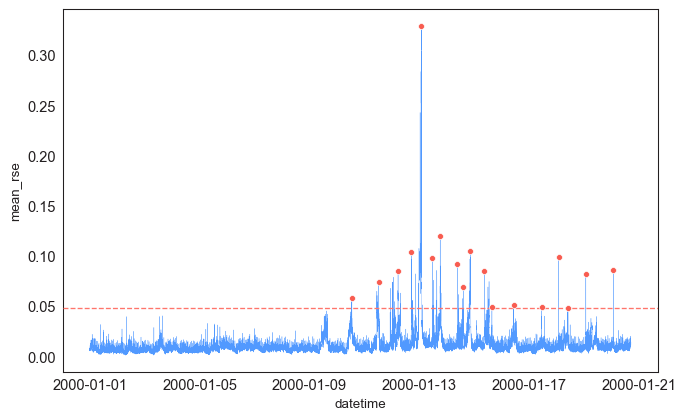

In [178]:
model.plot_extremes()

In [150]:
model.fit_model()
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                      mean_rse      Size:                              28,378
Start:                       January 2000      End:                         January 2000
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 18      Extraction method:                    POT
Type:                                high      Threshold:           0.048487280009327505
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='mean_rse'>,
  <AxesSubplot:title={'center':'Probability density plot'}, xlabel='mean_rse', ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

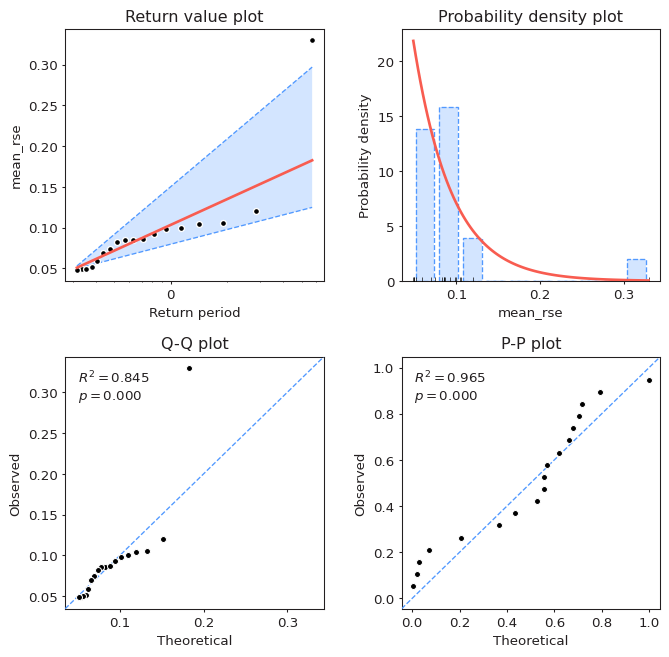

In [151]:
model.plot_diagnostic(alpha=0.95)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Threshold', ylabel='Mean excess'>)

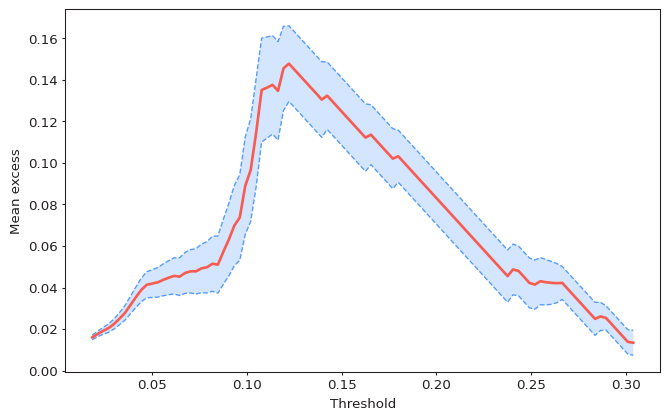

In [156]:
pyextremes.plot_mean_residual_life(ts=x_i)

(<Figure size 768x480 with 2 Axes>,
 (<AxesSubplot:ylabel='Shape, $\\xi$'>,
  <AxesSubplot:xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>))

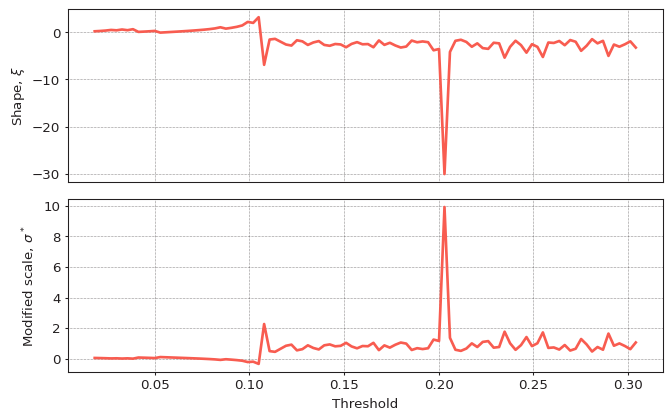

In [157]:
pyextremes.plot_parameter_stability(ts=x_i)

In [165]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('POT') #installing POT package

R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/el-capitan/contrib/3.6/POT_1.1-7.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1399205 bytes (1.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


The downloaded binary packages are in
	/var/folders/r7/3_z3p06n3m79fcylhf7268r00000gn/T//RtmpZVcPlE/downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f8cc033a100> [RTYPES.NILSXP]

In [166]:
from thresholdmodeling import thresh_modeling

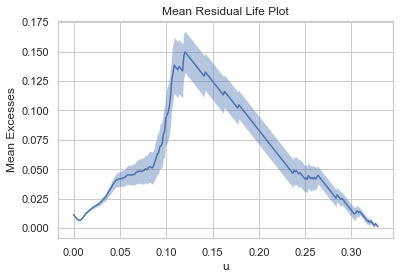

ValueError: Not an rpy2 R object and unable to map it into one: 0.0

In [169]:
thresh_modeling.MRL(x_i.values, 0.05)   
thresh_modeling.Parameter_Stability_plot(x_i.values, 0.05)

In [171]:
thresh_modeling.gpdfit(x_i, 0.04, 'mle')

Estimator: MLE 
 Deviance: -2543.882 
      AIC: -2539.882 

Varying Threshold: FALSE 

  Threshold Call: 0.04 
    Number Above: 508 
Proportion Above: 0.0179 

Estimates
  scale    shape  
0.01909  0.45584  

Standard Error Type: observed 

Standard Errors
  scale    shape  
0.00151  0.06896  

Asymptotic Variance Covariance
       scale       shape     
scale   2.279e-06  -6.547e-05
shape  -6.547e-05   4.756e-03

Optimization Information
  Convergence: successful 
  Function Evaluations: 57 
  Gradient Evaluations: 11 




(0.4558436534478324,
 0.019090373976198872,
 array([0.00160636, 0.00170884, 0.00197044, ..., 0.32482473, 0.32561872,
        0.32970429]),
 [2.472677934210743e-05,
  3.7888593894738753e-05,
  6.419630947367139e-05,
  0.00010020672773684153,
  0.00010082241686842214,
  0.00011718134331577951,
  0.00013397560552631804,
  0.00016177174321051896,
  0.00017515858042631283,
  0.00017558678850000675,
  0.0001766471776315781,
  0.00019129916131578606,
  0.0002593549749473692,
  0.0002620020995413169,
  0.0002710981916578953,
  0.0002899818942105198,
  0.0002921606539473681,
  0.0003451299717631487,
  0.00035081754531578885,
  0.0003881904854736856,
  0.00040949842368420697,
  0.0004114594148157749,
  0.00043838864976316477,
  0.0004475817552631531,
  0.00046056817998948313,
  0.0004917309547368479,
  0.0005094593870263245,
  0.0005777743211315758,
  0.0005935296499473761,
  0.0006578426466315804,
  0.0006911568138605328,
  0.0006920382877894787,
  0.0007022820673947341,
  0.0008309669692631652

Estimator: MLE 
 Deviance: -2543.882 
      AIC: -2539.882 

Varying Threshold: FALSE 

  Threshold Call: 0.04 
    Number Above: 508 
Proportion Above: 0.0179 

Estimates
  scale    shape  
0.01909  0.45584  

Standard Error Type: observed 

Standard Errors
  scale    shape  
0.00151  0.06896  

Asymptotic Variance Covariance
       scale       shape     
scale   2.279e-06  -6.547e-05
shape  -6.547e-05   4.756e-03

Optimization Information
  Convergence: successful 
  Function Evaluations: 57 
  Gradient Evaluations: 11 




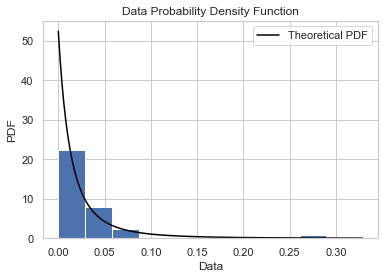

Estimator: MLE 
 Deviance: -2543.882 
      AIC: -2539.882 

Varying Threshold: FALSE 

  Threshold Call: 0.04 
    Number Above: 508 
Proportion Above: 0.0179 

Estimates
  scale    shape  
0.01909  0.45584  

Standard Error Type: observed 

Standard Errors
  scale    shape  
0.00151  0.06896  

Asymptotic Variance Covariance
       scale       shape     
scale   2.279e-06  -6.547e-05
shape  -6.547e-05   4.756e-03

Optimization Information
  Convergence: successful 
  Function Evaluations: 57 
  Gradient Evaluations: 11 




ValueError: x and y must have same first dimension, but have shapes (508,) and (505,)

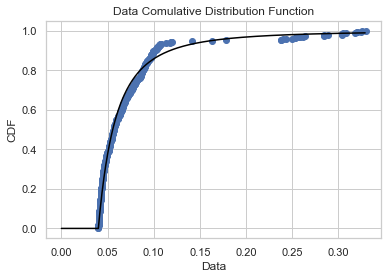

In [172]:
thresh_modeling.gpdpdf(x_i, 0.04, 'mle', 'sturges', 0.05)
thresh_modeling.gpdcdf(x_i, 0.04, 'mle', 0.05)
thresh_modeling.qqplot(x_i, 0.04, 'mle', 0.05)
thresh_modeling.ppplot(x_i, 0.04, 'mle', 0.05)